Testarea algoritmului Mask R-CNN pentru dastaset-ul cu vapoare de la Airbus


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
#from mrcnn.model import log

from PIL import Image

from samples.boat import boat
def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

Using TensorFlow backend.


Configuratii

In [2]:
config = boat.BoatConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/boat")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Incarcam dataset-ul de validare

In [7]:
# Load validation dataset
director = ROOT_DIR;
dataset = boat.BoatDataset()
dataset.load_boat(ROOT_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 162
Classes: ['BG', 'boat']


Incarcam modelul

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [10]:
# Set path to balloon weights file

# Or, load the last model you trained
#weights_path = model.find_last()
weights_path = "C:/Users/Lala Timotei/Mask_RCNN-master/logs/boat20181124T1302/mask_rcnn_boat_0030.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:/Users/Lala Timotei/Mask_RCNN-master/logs/boat20181124T1302/mask_rcnn_boat_0030.h5
Re-starting from epoch 30


Testam diferite poze din folderul .../val. Selectarea pozelor se face 

C:\Users\Lala Timotei\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


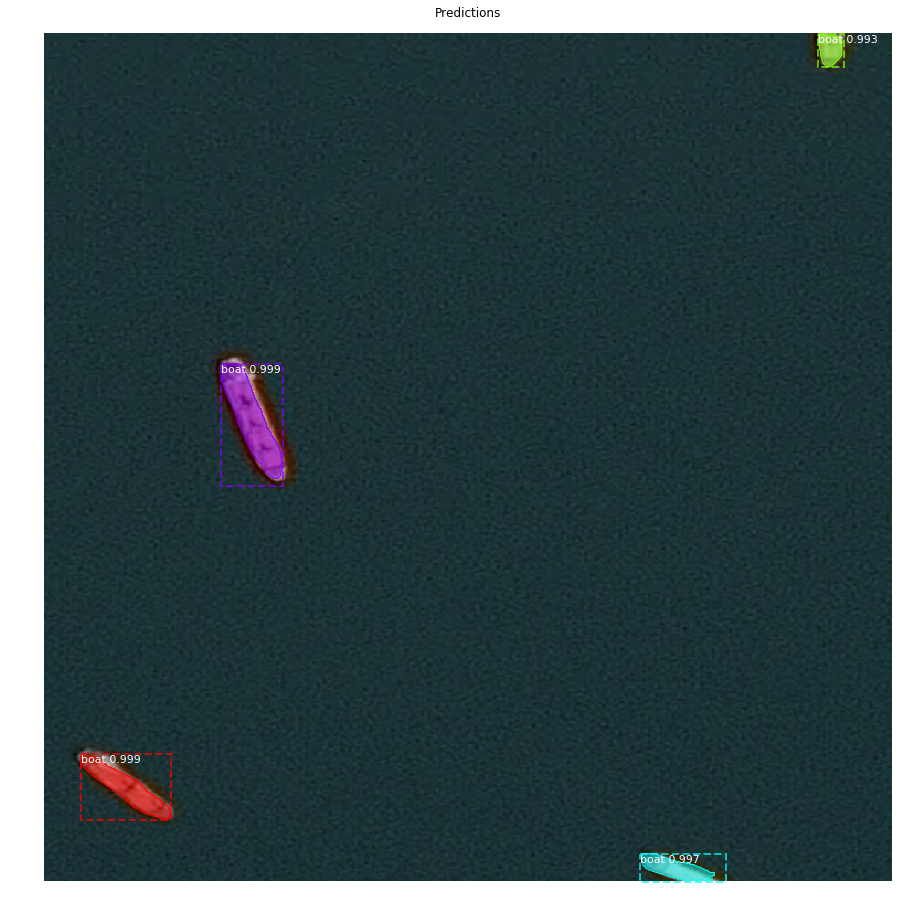

In [12]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

#imaginea de test se schimba de aici
image = np.asarray(Image.open('C:/Users/Lala Timotei/Mask_RCNN-master/val/0f01e20db.jpg', 'r'))
# Run object detection
results = model.detect([image], verbose=0)

# Display results
ax = get_ax(1)
r = results[0]
#Incercare de a afisa masca 
colors = [1, 0.0, 0.0]
masks = r['masks'] #iau toate mastile detectate de algoritmul meu 
mask = masks[:, :, 0]#iau doar prima masca detectata
masked_image = image.astype(np.uint32).copy()
masked_image = apply_mask(masked_image, mask, colors)#aplicam masca pe poza
imgplot = plt.imshow(masked_image)#afisam poza cu tot cu masca
#plt.show()


visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                           title="Predictions")